In [1]:
import glob
import seaborn as sns


import matplotlib.pyplot as plt

import json
import copy
import logging
import os
import random
import re
import subprocess
from typing import Any, Dict, List

import numpy as np
import pandas as pd
from tf_agents.environments import py_environment
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.typing import types
from tf_agents.policies.random_py_policy import RandomPyPolicy

# Test

In [70]:
class JVMState:
    def __init__(self, flags=[], params=[], goals=[]):
        self._flags = flags
        self._params = params
        self._goals = goals
    
    def get_list(self):
        return np.array(
            [*self._flags, *self._params, *self._goals])
    
    def get_flags(self):
        return self._flags
    
    def get_params(self):
        return self._params
    
    def get_goals(self):
        return self._goals
    
    def set_flags(self, flags):
        self._flags = flags
    
    def set_params(self, params):
        self._params = params
    
    def set_goals(self, goals):
        self._goals = goals
    
        

class JVMEnv(py_environment.PyEnvironment):

    def __init__(
        self,
        jdk_path: str,
        bm_path: str,
        gc_viewer_jar: str,
        callback_path: str,
        goals: List,
        flags: List,
        params: List,
        default_flags: List,
        bm_name: str = "avrora",
        n: int = 5,
        verbose: bool = False,
    ):

        self.jdk = jdk_path
        self.bm_path = bm_path
        self.gc_viewer_jar = gc_viewer_jar
        self.callback_path = callback_path
        self._bm = bm_name
        self._gc_log_file = f"gc-{self._bm}.txt"
        self._n = n
        self._goals = goals
        self._flags = flags
        self._params = params
        self._default_flags = default_flags
        self._verbose = verbose
        print("jdk_path: ", jdk_path)
        
        self._env = os.environ.copy()
        self._env["PATH"] = f"{self.jdk}:{self._env['PATH']}"
        
        self._episode_ended = False

        # ============= F L A G S =============
        self._num_flags = len(self._flags)
        self._num_params = len(self._params)
        self._num_goals = len(self._goals)
        # TODO: Find min and max values for flags
        # self._goal_idx = self._num_flags
        # self._flags = {
        #     "MaxTenuringThreshold": {"min": 1, "max": 16, "step": 3},
        #     "ParallelGCThreads": {"min": 4, "max": 24, "step": 4},
        # }

        # self._action_mapping = {
        #     0: self._decrease_MaxTenuringThreshold,
        #     1: self._increase_MaxTenuringThreshold,
        #     2: self._decrease_ParallelGCThreads,
        #     3: self._increase_ParallelGCThreads,
        # }
        # =====================================

        # assert (
        #     len(self._action_mapping) == 2 * self._num_flags
        # ), "Each flag should have 2 actions!"

        # self._flags_min_values = [self._flags[i]["min"] for i in self._flags.keys()]
        # self._flags_max_values = [self._flags[i]["max"] for i in self._flags.keys()]
        # self._flags_step_values = [self._flags[i]["step"] for i in self._flags.keys()]
        
        self._flags_min_values = [flag["min"] for flag in self._flags]
        self._flags_max_values = [flag["max"] for flag in self._flags]
        self._flags_step_values = [flag["step"] for flag in self._flags]

        self._action_spec = array_spec.BoundedArraySpec(
            shape = (self._num_flags, ),
            dtype = np.int32,
            minimum = np.array(self._flags_min_values),
            maximum = np.array(self._flags_max_values),
            name = "action",
        )

        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(self._num_flags + self._num_goals + self._num_params,),  # 1 goal, {X} external vars
            dtype=np.float32,
            name="observation",
        )

        # # For offline RL: if you already have a dataset file with trajectories.
        self._new_df = pd.read_csv(f"datasets/large_{self._bm}_real_saved_states.csv")

        self._default_state = self._get_default_state(mode="default")
        # self._default_state = self._get_default_state(mode="random")

        self._perf_states = {}
        self._perf_states[0] = {
            "flags": self._default_state.get_flags(),
            "goal": self._default_state.get_goals(),
            "params": self._default_state.get_params(),
            "count": 1,
        }

        self._print_welcome_msg()

    @property
    def jdk(self):
        return self._jdk

    @jdk.setter
    def jdk(self, path: str):
        if not os.path.exists(path):
            raise FileNotFoundError(path)
        self._jdk = os.path.join(path, "bin")

    @property
    def bm_path(self):
        return self._bm_path

    @bm_path.setter
    def bm_path(self, path: str):
        if not os.path.exists(path):
            raise FileNotFoundError(path)
        self._bm_path = os.path.join(path)

    @property
    def gc_viewer_jar(self):
        return self._gc_viewer_jar

    @gc_viewer_jar.setter
    def gc_viewer_jar(self, path: str):
        if not os.path.exists(path):
            raise FileNotFoundError(path)
        self._gc_viewer_jar = os.path.join(path)

    @property
    def callback_path(self):
        return self._callback_path

    @callback_path.setter
    def callback_path(self, path: str):
        if not os.path.exists(path):
            raise FileNotFoundError(path)
        self._callback_path = os.path.join(path)


    def action_spec(self):
        """Get the actions that should be provided to `step()`."""
        return self._action_spec

    def observation_spec(self):
        """Get the the observations provided by the environment."""
        return self._observation_spec

    def _reset(self):
        """
        Resets the environment state.

        This method must be called before :func:`step()`.

        Returns:
            A `TimeStep` namedtuple containing:
                step_type: A `StepType` of `FIRST`.
                reward: 0.0, indicating the reward.
                discount: 1.0, indicating the discount.
                observation: A NumPy array, or a nested dict,
                list or tuple of arrays
                corresponding to `observation_spec()`.
        """
        self._episode_ended = False

        # To ensure all elements within an object array are copied, use `copy.deepcopy`
        self._default_state = self._get_default_state(mode="random")
        # self._default_state = self._get_default_state(mode="default")
        
        self._state = copy.deepcopy(self._default_state)

        logging.debug(
            f"[RESET] {self._get_info()}, target: {self._state[self._goal_idx]}"
        )
        return ts.restart(np.array(self._state, dtype=np.float32))

    def _step(self, action: types.NestedArray):
        """Updates the environment according to action.

        Parameters:
            action: A NumPy array, or a nested dict, list or tuple of arrays
                corresponding to `action_spec()`.
        Returns:
            A `TimeStep` namedtuple containing:
                step_type: A `StepType` of `FIRST`.
                reward: 0.0, indicating the reward.
                discount: 1.0, indicating the discount.
                observation: A NumPy array, or a nested dict, list or tuple of arrays
                corresponding to `observation_spec()`.
        """
        if self._episode_ended:
            # The last action ended the episode.
            # Ignore the current action and start a new episode.
            logging.debug(
                f"[EPISODE ENDED] {self._get_info()}, target: {self._state[self._goal_idx]}"
            )
            return self.reset()
        # Apply an action based on the mapping: decrease/increase <flag.value>.
        self._action_mapping.get(int(action))()

        # Make sure we don't leave the boundaries.
        self._state = self._clip_state(self._state)

        # Check if the current JVM configuration is cached.
        # Add `state` to cache if new.
        self._state = copy.deepcopy(
            self._state_merging(self._state[: self._num_flags])
        )

        # Termination criteria
        if self._state[self._goal_idx] <= self._default_state[self._goal_idx] * 0.04:
            self._episode_ended = True

        self._reward = self._get_reward(
            current_state=self._state,
            previous_state=self._default_state,
            lower_is_better=True,
            beta=0.0,
        )  # ! No intrinsic reward

        logging.debug(
            f"[STEP] {self._get_info()}, target: {self._state[self._goal_idx]}"
        )

        if self._episode_ended:
            return ts.termination(np.array(self._state, dtype=np.float32), reward=2.0)
        else:
            return ts.transition(
                np.array(self._state, dtype=np.float32),
                reward=self._reward,
                discount=0.5,
            )

    def _state_merging(self, flags):
        """
        Store states' JVM configurations and performance measurements
        in a cache. The cache stores the JVM flags and the metric goal.
        In each `self._step` iteration, the performance of the same
        state is queried and retrieved directly from the cache instead
        of re-running the benchmark utility.
        Han, Xue & Yu, Tingting. (2020).
        Automated Performance Tuning for Highly-Configurable Software Systems.

        0: {"flags": [10, 10], "goal": [234], "params": [150, 0.1, 30, 19], "count": 1},
        1: {"flags": [10, 20], "goal": [222], "params": [140, 0.2, 29, 18], "count": 4},
        ...
        """
        saved_states = [self._perf_states[i]["flags"] for i in self._perf_states.keys()]
        state = JVMState()
        if flags == self._default_state.get_flags():
            state = self._default_state
        elif flags in saved_states:
            """
            If current state is stored in a cache,
            update the state goal value.
            """
            idx = saved_states.index(flags)
            self._perf_states[idx]["count"] += 1
            
            goal = self._perf_states[idx]["goal"]
            params = self._perf_states[idx]["params"]
            
            state = JVMState(flags, params, goal)
        else:
            """
            If current state is not stored in the cache,
            measure the performance metric, and save it
            in the cache.
            """
            try:
                last_index = list(self._perf_states.keys())[-1]
            except IndexError:
                # If `self._perf_states` is empty
                last_index = -1
                
            # Launch a benchmark with a new JVM configuration
            state = self._synthetic_run(flags)
            
            # Store a new state in the cache, count = 1.
            self._perf_states[last_index + 1] = {
                "flags": state.get_flags(),
                "goal": state.get_goals(),
                "params": state.get_params(),
                "count": 1,
            }
            
        assert len(state.get_list()) != 0, "State is empty!"
        
        return state

    def _synthetic_run(self, flag_values: List[int]):
        flag_names = [each["name"] for each in self._flags]
        goal_names = [each["name"] for each in self._goals]
        param_names = self._params
        
        # Select columns where flags equal to flag_values
        param_values = (
            self._new_df.set_index(flag_names)
            .loc[tuple(flag_values), param_names]
            .values
        )

        goal_values = (
            self._new_df.set_index(flag_names)
            .loc[tuple(flag_values), goal_names]
            .values
        )

        state = JVMState(
            flags=flag_values,
            params=param_values,
            goals=goal_values,
        )
        
        return state

    def _get_JVM_opt_value(self, opt: str):
        """
        Get the default JVM option value from environment
        by parsing java PrintFlagsFinal output.
        Equals to bash command:
        java -XX:+PrintFlagsFinal -version|grep "$opt"|

        Parameters:
        opt (str): JVM option name

        Returns:
        (int) Default JVM option value
        """
        opt_value = None

        flags = subprocess.check_output(
            ["java", "-XX:+PrintFlagsFinal", "-version"], text=True, env=self._env
        )

        assert re.search(opt, flags), f"Option {opt} was not found in JVM flags"

        for line in flags.split("\n"):
            if re.search(opt, line):
                opt_value = re.findall("\d+", line)[0]
                # TODO: Handle boolean values
                return int(opt_value)

    def _get_info(self):
        info = {}
        flags = list(self._flags.keys())
        for flag in flags:
            flag_idx = flags.index(flag)
            flag_value = self._state[flag_idx]
            info[flag] = flag_value
        return info

    def _get_default_state(self, mode: str = "default"):
        """
        Get default values for each JVM option stored in `self._flags`
        from `java -XX:+PrintFlagsFinal -version` command output.
        Also runs a benchmark with default JVM_OPTS and get the initial
        goal value.

        Parameters:
        mode (str): The mode of generating JVM options (default/minimum/random)
                    where
                    - "default" sets JVM_OPTS default JDK options,
                    - "minimum" sets JVM_OPTS minimum possible values,
                    - "random" sets JVM_OPTS random values within options
                    range.

        Returns:
        (np.array) The initial state of the Agent which stores the default
        JVM_OPTS and its performance measurement.
        """
        assert mode in ["default", "random"], f"Unknown mode: {mode}"
        
        run_flags = []
        
        if mode == "default":
            run_flags = [7, 12]
        if mode == "random":
            for i in range(self._num_flags):
                
                min_val = self._flags_min_values[i]
                max_val = self._flags_max_values[i]
                step_val = self._flags_step_values[i]
                
                run_flags.append(
                    random.randrange(
                        start=min_val,
                        stop=max_val + step_val,  # must be included
                        step=step_val,
                    )
                )
                
        state = self._synthetic_run(run_flags)
        return state

    def _get_goal_value(self, jvm_opts: List[str] = []):
        """
        Run the benchmark with default values and
        get a start point of the goal.

        Parameters:
        jvm_opts (list): An array of JVM options.

        Returns:
        (int) A performance measurement (target metric
        or goal value).
        """
        # Run benchmark with default values
        self._run(
            jvm_opts,
            self._gc_log_file,
            self._bm,
            self.bm_path,
            self.callback_path,
            self._n,
        )

        if os.path.exists(self._gc_log_file):
            # Get goal value from first-time generated GC log
            result = self._get_goal_from_file()
            # Clean up
            os.remove(self._gc_log_file)
            return result
        else:
            raise Exception(
                "GC log file was not generated: please, ensure that benchmark runs correctly!"
            )

    def _clip_state(self, state):
        for i in range(self._num_flags):
            """
            Iterate through each flag value in `state`
            and use `np.clip` to make sure we don't leave
            the boundaries
            """
            min_value_i = self._flags_min_values[i]
            max_value_i = self._flags_max_values[i]
            state[i] = np.clip(state[i], min_value_i, max_value_i)
        return state

    def _get_goal_from_file(self):
        sep = ";"
        summary = "summary.csv"
        goal_value = None
        subprocess.call(
            [
                "java",
                "-cp",
                self.gc_viewer_jar,
                "com.tagtraum.perf.gcviewer.GCViewer",
                self._gc_log_file,
                summary,
                "-t",
                "SUMMARY",
            ],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.STDOUT,
            text=True,
            env=self._env,
        )

        assert os.path.exists(summary), f"File {summary} does not exist"

        with open(summary, "+r") as summary_file:
            for line in summary_file.readlines():
                if self._goal + sep in line:
                    goal_value = float(line.split(sep)[1])

        if goal_value == None:
            raise Exception(f"Goal '{self._goal}' was not found in '{summary}'!")

        if os.path.exists(summary):
            os.remove(summary)

        return goal_value

    def _get_reward(
        self,
        current_state: JVMState,
        previous_state: JVMState,
        lower_is_better: bool = False,
        beta: float = 1.0,
    ):
        """
        Get the environment reward. The reward is composed of two terms:
            `reward = reward_ex + beta * reward_in`,
        where `beta` is a hyperparameter adjusting the balance between
        exploitation and exploration.
        - reward_ex is an extrinsic reward from the environment at time `t`.
        - reward_in is an intrinsic exploration bonus.
        Parameters:
            current_state (np.array):   Current state containing JVM flags
                                        and goal value.
            previous_state (np.array):  Previous state containing JVM flags
                                        and goal value.
            lower_is_better (bool):     Whether to consider lower goal values
                                        better than larger ones. So that reward
                                        is positive.
            beta (float):               Importance of instrinsic rewards ([0.0, 1.0]).
        Returns:
            reward (float):             An environment reward value at current
                                        time step.
        """
        coef = -1 if lower_is_better else 1
        reward_in = 0  # Intrinsic reward.
        reward_ex = 0  # Extrinsic reward.

        # TODO: Check if beta is in range [0, 1]

        assert len(current_state.get_goals()) == 1, "Multi-objective is not supported"

        # JVMState supports multiple goal values,
        # so we paramsct a single number from 1D array
        # TODO: Add multi-objective support
        current_goal = current_state.get_goals()[0]
        previous_goal = previous_state.get_goals()[0]

        if coef * current_goal <= previous_goal:
            for i in self._perf_states.keys():
                if self._perf_states[i]["flags"] == current_state.get_flags():
                    # First, we add the state to cache with count=1,
                    # but we haven't run the benchmark with it yet,
                    # so it is fair to say that actually count is 0.
                    count = self._perf_states[i]["count"] - 1
                    reward_in = (count + 0.01) ** (-1 / 2)
            reward_ex = coef * (current_goal - previous_goal) / previous_goal
            reward = reward_ex + beta * reward_in
            reward = round(reward, 4)
        else:
            reward = -1

        return reward


    def _get_jvm_opts(self, flags):
        jvm_opts = []
        for flag_name in self._flags.keys():
            i = list(self._flags.keys()).index(flag_name)
            # `state[:self._num_flags]` stores an array of current
            # flag values [<MaxHeapSize>, <InitialHeapSize>]
            flag_value = int(flags[i])
            # TODO: Add a condition for flags with boolean values
            # TODO: Add a unit!
            jvm_opts.append(f"-XX:{flag_name}={flag_value}")
        return jvm_opts

    def _run(
        self,
        jvm_opts: List[str],
        gc_log_file: str,
        bm: str,
        bm_path: str,
        callback_path: str,
        n: int = 5,
        verbose: bool = False,
    ):
        """
        Run a benchmark with the specified JVM options
        such as MaxHeapSize.

        Parameters:
        jvm_opts (array of str):  JVM options (e.g., MaxHeapSize, GCTimeRation,
                                ParallelGCThreads, etc).
        gc_log_file (str):        Path to the garbage collector log file (txt).
        bm (str):                 DaCapo benchmark name.
        bm_path (str):            DaCapo benchmark path.
        n (int):                  Total number of benchmark's iterations.
        verbose (bool):           Print debug messages.
        """

        if not os.path.exists(callback_path):
            raise FileNotFoundError(callback_path)

        # Clean up before running the benchmark
        try:
            os.remove(gc_log_file)
        except FileNotFoundError:
            pass

        # Default flags
        jvm_opts.append(*self._default_flags)
        # jvm_opts.append("-XX:+UseParallelGC")
        # jvm_opts.append("-Xmx16G")
        # jvm_opts.append("-Xms16G")
        # jvm_opts.append("-XX:SurvivorRatio=130")
        # jvm_opts.append("-XX:TargetSurvivorRatio=66")

        # Run the benchmark (hide output)
        try:
            subprocess.check_output(
                [
                    "java",
                    "-cp",
                    f"{callback_path}:{bm_path}",
                    f"-Xlog:gc*=trace:file={gc_log_file}:tags,time,uptime,level",
                    *jvm_opts,
                    "-Dvmstat.enable_jfr=yes",
                    "-Dvmstat.csv=yes",
                    "Harness",
                    "-v",
                    "-n",
                    f"{n}",
                    bm,
                ],
                stderr=subprocess.STDOUT,
                text=True,
                env=self._env,
            )
        except subprocess.CalledProcessError as e:
            raise Exception("Command failed with return code", e.returncode, e.output)

        return

    def _render(self):
        raise NotImplementedError("This environment has not implemented `render().'")

    def _print_welcome_msg(self):
        print(
            "Successfully initialized a JVM Environment!\n",
            f"JDK: {self.jdk},\n",
            f"Benchmark: {self._bm} ({self.bm_path}),\n",
            f"Number of iterations: {self._n},\n",
            f"Goals: {self._goals},\n",
            f"Number of JVM options: {self._num_flags},\n",
            f"JVM options: {self._flags},\n",
            # f"Env. default state: {self._default_state},\n",
            # f"Env. default goal value: {self._default_state[self._goal_idx]},\n",
        )


In [71]:
JVMState().get_list()

array([], dtype=float64)

In [14]:
current_state = JVMState(
    flags = [7, 12],
    params= [0.005, 123.45, 99.0],
    goals = [0.005]
)

previous_state = JVMState(
    flags = [7, 14],
    params= [0.0055, 126.45, 101.0],
    goals = [0.01]
)



In [64]:
with open("env_config_3flags.json", "r") as config:
    env_properties = json.load(config)

env = JVMEnv(**env_properties)

jdk_path:  jdk-11.0.20.1.jdk
Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: avrora (dacapo-bench.jar),
 Number of iterations: 5,
 Goals: [{'name': 'footprint', 'minimize': True}],
 Number of JVM options: 3,
 JVM options: [{'name': 'MaxTenuringThreshold', 'min': 1, 'max': 16, 'step': 3}, {'name': 'ParallelGCThreads', 'min': 4, 'max': 24, 'step': 4, 'unit': ''}, {'name': 'MaxHeapSize', 'min': 2, 'max': 24, 'step': 4, 'unit': 'G'}],



/var/folders/dn/p1_3j9fs78g4wn8r0hcrqks40000gn/T/ipykernel_94487/2109101939.py:324: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._new_df.set_index(flag_names)
/var/folders/dn/p1_3j9fs78g4wn8r0hcrqks40000gn/T/ipykernel_94487/2109101939.py:330: PerformanceWarning: indexing past lexsort depth may impact performance.
  self._new_df.set_index(flag_names)


In [66]:
current_state.get_goals()

[0.005]

In [68]:
previous_state.get_goals()

[0.01]

In [65]:
env._get_reward(
    current_state,
    previous_state,
    lower_is_better=True
)

10.5

In [38]:
random_policy = RandomPyPolicy(
    None,
    action_spec
)

In [46]:
random_policy.action(None).action

array([ 3,  6, 15], dtype=int32)

In [ ]:
class JVMAction:
    def __init__(self, flag_name):
        self._flag_name = flag_name
    
    def 

jdk_path:  jdk-11.0.20.1.jdk


KeyError: 'Key length (7) exceeds index depth (3)'

# 1

In [16]:
include_cols = [
    "fullGCPause",
    "avgPause",
    "fullGcPauseCount",
    "footprint",
    "gcPerformance",
    "totalTenuredUsedMax",
    "avgPromotion",
    "fullGCPerformance",
    "throughput"
]

all_dfs = []

def get_processed_df(csv_file):
    processed_df = pd.read_csv(csv_file, sep=';', skiprows=1)
    processed_df = processed_df.replace(',','', regex=True)
    processed_df = processed_df.replace('n.a.','NaN', regex=True)
    processed_df = processed_df[processed_df.iloc[:, 0].isin(include_cols)]
    processed_df.index = processed_df.iloc[:, 0]
    processed_df = processed_df.transpose().iloc[1:2, :] # .astype(float).values 
    return processed_df

for summary in glob.glob("summaries_avrora/*.csv"): # glob.glob("summaries_avrora/*.csv") + 
    df = get_processed_df(summary)
    
    all_dfs.append(df)

In [17]:
frame = pd.concat(all_dfs,)
frame

totalHeapAllocMax,totalTenuredUsedMax,avgPromotion,avgPause,fullGcPauseCount,fullGCPause,footprint,throughput,gcPerformance,fullGCPerformance
"1,508",3355,64.8,0.03712,5,0.33,1508,99.7,14920.584,6134.62
"1,508",3355,103.2,0.04522,5,0.41,1508,99.64,14959.635,4953.668
"1,508",3409,-66765,0.04362,5,0.4,1508,99.71,16238.272,5117.301
"1,508",3355,-150528,0.04677,5,0.42,1508,99.7,13366.383,4824.204
"1,508",3354,-236954,0.05045,5,0.46,1508,99.67,13693.046,4424.913
...,...,...,...,...,...,...,...,...,...
"1,508",4748,19,0.04687,5,0.42,1508,99.69,13714.105,9793.49
"1,508",3411,-89702,0.04654,5,0.42,1508,99.68,14191.244,4830.485
"1,508",3380,-137421,0.0536,5,0.49,1508,99.24,13323.378,4152.97
"1,508",3355,-114893,0.04662,5,0.42,1508,99.69,13341.199,4851.689


In [18]:
# Transpose.
# frame = frame.T

# Remove constant values.
frame = frame.loc[:, (frame != frame.iloc[0]).any()]

print("Total number of selected parameters:", len(include_cols))
print("Number of filtered parameters:", len(frame.columns))

Total number of selected parameters: 9
Number of filtered parameters: 7


In [13]:
frame.corr()

totalHeapAllocMax,totalHeapUsedMax,totalHeapUsedMaxpc,totalTenuredUsedMax,totalYoungUsedMax,totalYoungUsedMaxpc,avgPromotion,promotionTotal,avgGCPause
totalHeapAllocMax,,,,,,,,
totalHeapUsedMax,1.000000,1.000000,0.163403,1.000000,1.000000,-0.023649,-0.023649,0.033075
totalHeapUsedMaxpc,1.000000,1.000000,0.163403,1.000000,1.000000,-0.023649,-0.023649,0.033075
totalTenuredUsedMax,0.163403,0.163403,1.000000,0.163403,0.163403,-0.047795,-0.047794,0.146599
totalYoungUsedMax,1.000000,1.000000,0.163403,1.000000,1.000000,-0.023649,-0.023649,0.033075
totalYoungUsedMaxpc,1.000000,1.000000,0.163403,1.000000,1.000000,-0.023649,-0.023649,0.033075
avgPromotion,-0.023649,-0.023649,-0.047795,-0.023649,-0.023649,1.000000,1.000000,-0.361351
promotionTotal,-0.023649,-0.023649,-0.047794,-0.023649,-0.023649,1.000000,1.000000,-0.361351
avgGCPause,0.033075,0.033075,0.146599,0.033075,0.033075,-0.361351,-0.361351,1.000000


<Axes: xlabel='totalHeapAllocMax', ylabel='totalHeapAllocMax'>

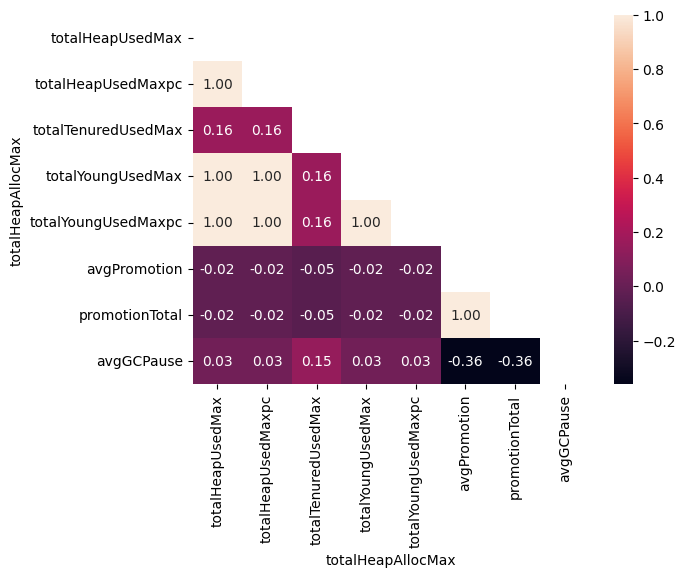

In [14]:
fig, ax = plt.subplots() # figsize=(8, 8)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(frame.corr(), dtype=bool))

sns.heatmap(frame.corr(), ax=ax, fmt=".2f", annot=True, mask=mask)

In [15]:
# Correlation with output variable
cor_target = frame.corr()["avgGCPause"].sort_values()
# cor_target = frame.corr()["gcPerformance"].sort_values()
print("Number of correlated parameters:", len(cor_target) - 1)
cor_target

Number of correlated parameters: 7


totalHeapAllocMax
avgPromotion          -0.361351
promotionTotal        -0.361351
totalHeapUsedMaxpc     0.033075
totalHeapUsedMax       0.033075
totalYoungUsedMax      0.033075
totalYoungUsedMaxpc    0.033075
totalTenuredUsedMax    0.146599
avgGCPause             1.000000
Name: avgGCPause, dtype: float64

### Extra parameters (Avrora)

In [16]:
print("Initial list of parameters:\n", "\n".join(include_cols))

Initial list of parameters:
 totalHeapAllocMax
totalHeapUsedMax
totalHeapUsedMaxpc
totalTenuredAllocMax
totalTenuredUsedMax
totalTenuredUsedMaxpc
totalYoungAllocMax
totalYoungUsedMax
totalYoungUsedMaxpc
avgPromotion
promotionTotal
avgGCPause


The following parameters did not change over time and were excluded from the list.
- totalHeapAllocMax
- totalYoungAllocMax
- totalTenuredUsedMaxpc
- totalTenuredAllocMax


1. avgPromotion (-0.36, negative correlation)
2. promotionTotal (-0.36, negative correlation)
3. totalHeapUsedMaxpc (0.033075)
4. totalHeapUsedMax (0.033075)
5. totalYoungUsedMax (0.033075)
6. totalYoungUsedMaxpc (0.033075)
7. totalTenuredUsedMax (0.146599)

### Extra parameters (Kafka)

1. avgPromotion           0.183438
2. promotionTotal         0.183791
3. totalHeapUsedMaxpc    -0.021756
4. totalHeapUsedMax      -0.011937
5. totalYoungUsedMax     -0.011882
6. totalYoungUsedMaxpc   -0.007519
7. totalTenuredUsedMax    0.080765

### Random

In [38]:
flags = {
    "MaxTenuringThreshold": {"min": 1, "max": 16, "step": 3},
    "ParallelGCThreads": {"min": 4, "max": 24, "step": 4},
}

flags_min_values = [flags[i]["min"] for i in flags.keys()]
flags_max_values = [flags[i]["max"] for i in flags.keys()]
flags_step_values = [flags[i]["step"] for i in flags.keys()]

In [26]:
_num_variables=2

In [48]:
import random

random_state = []
for i in range(_num_variables):
    random_state.append(
        random.randrange(flags_min_values[i], flags_max_values[i], flags_step_values[i])
    )
random_state
# [random.randint(flags_min_values[i], flags_max_values[i]) for i in range(_num_variables)]
# random.randint(flags_min_values[0], flags_max_values[0])

[4, 12]

In [ ]:
[]

In [18]:
flags_min_values

[1, 4]